In [16]:
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import seaborn as sns
import spacy
import transformers
import torch

from datasets import Dataset
from hdbscan import HDBSCAN
from PIL import Image
from sentence_transformers import SentenceTransformer
from sklearn.cluster import (
    KMeans,
    AgglomerativeClustering
)
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForSeq2SeqLM
)
from umap import UMAP
from wordcloud import WordCloud

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


## Read data

In [17]:
data_dir = "../data"
train_data_path = os.path.join(data_dir, 'train_data_llava.json')
test_data_path = os.path.join(data_dir, 'test_data_llava.json')
models_dir = "../models"

def generate_df_from_json(json_path):
  with open(json_path) as f:
    data: dict = json.load(f)
    data_formated= {'caption': [], 'label': []}
    for value in data.values():
      data_formated['caption'].append(value['caption'])
      data_formated['label'].append(value['label'])
  
  df = pd.DataFrame.from_dict(data_formated)
  return df

id2label = {
  0: 'Cultural_Religious',
  1: 'Fauna_Flora',
  2: 'Gastronomy',
  3: 'Nature',
  4: 'Sports',
  5: 'Urban_Rural'
}

label2id = {
  'Cultural_Religious': 0,
  'Fauna_Flora': 1,
  'Gastronomy': 2,
  'Nature': 3,
  'Sports': 4,
  'Urban_Rural': 5
}

train_df = generate_df_from_json(train_data_path)
train_df['Label'] = train_df['label'].replace(id2label)
test_df = generate_df_from_json(test_data_path)
test_df['Label'] = test_df['label'].replace(id2label)

#train_data = Dataset.from_pandas(train_df).train_test_split(test_size=0.15, seed=4999)
#test_data = Dataset.from_pandas(train_df)
#print(train_data)

## Generate embeddings

In [18]:
embedding_model = SentenceTransformer("all-MiniLM-L12-v2").to('cuda')
#embedding_model = SentenceTransformer("paraphrase-MiniLM-L12-v2").to('cuda')
#embedding_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2").to('cuda')

def generate_embeddings(df: pd.DataFrame, text_col: str):
    sentences = df[text_col].tolist()
    embeddings = embedding_model.encode(sentences)

    return embeddings
    
train_embeddings = generate_embeddings(train_df, 'caption')
test_embeddings = generate_embeddings(test_df, 'caption')

## Dimensionality reduction (UMAP)

We are going to reduce dimensonality:
1. For documents visualization, with 2 dimensions
2. For documents clustering, with more dimensions

### For documents visualization

In [19]:
viz_reducer = UMAP(n_neighbors=15, n_components=2, metric='cosine')
viz_train_reduced = viz_reducer.fit_transform(train_embeddings)

<Axes: xlabel='x', ylabel='y'>

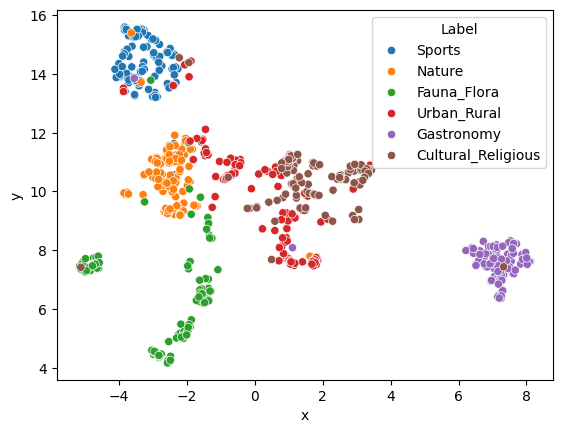

In [20]:
train_df['x'] = viz_train_reduced[:, 0]
train_df['y'] = viz_train_reduced[:, 1]
sns.scatterplot(
    train_df, x='x', y='y', 
    hue='Label', 
    palette=sns.color_palette("tab10", n_colors=6)
)

### For clustering

In [21]:
reducer = UMAP(n_neighbors=15, n_components=20, metric='cosine')
train_reduced = reducer.fit_transform(train_embeddings)

## Clustering

### HDBSCAN

In [22]:
clusterer = HDBSCAN(min_cluster_size=20, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
clusterer.fit(train_reduced)

HDBSCAN(min_cluster_size=20, prediction_data=True)

/tmp/ipykernel_41861/1165245163.py:2: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  ax = sns.scatterplot(


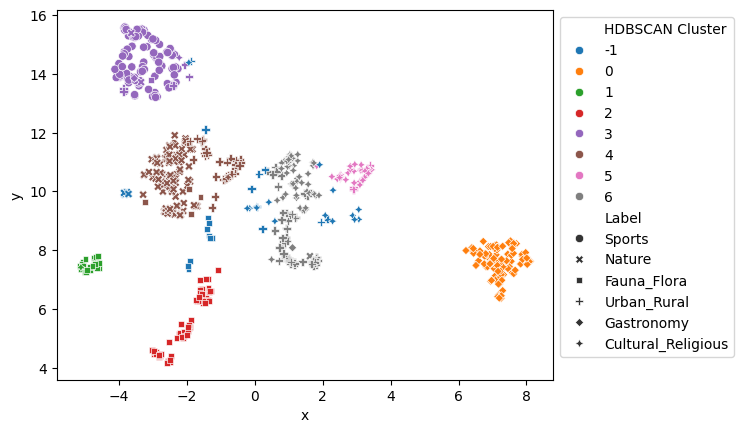

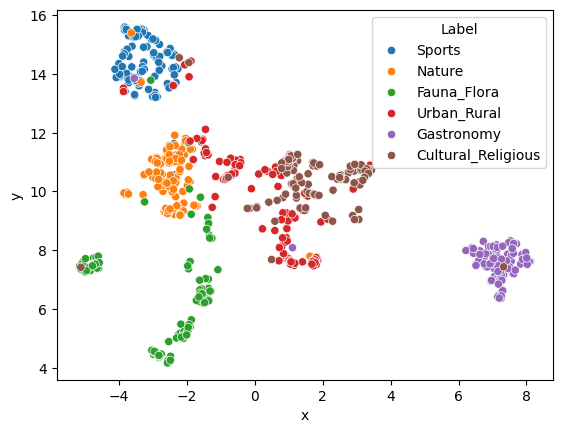

In [23]:
train_df['HDBSCAN Cluster'] = clusterer.labels_
ax = sns.scatterplot(
    train_df, x='x', y='y', hue='HDBSCAN Cluster', style='Label',
    palette=sns.color_palette("tab10", n_colors=10)
)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Position outside the plot
plt.show()

sns.scatterplot(
    train_df, x='x', y='y', hue='Label', 
    palette=sns.color_palette("tab10", n_colors=6)
)
plt.show()

<Axes: ylabel='$\\lambda$ value'>

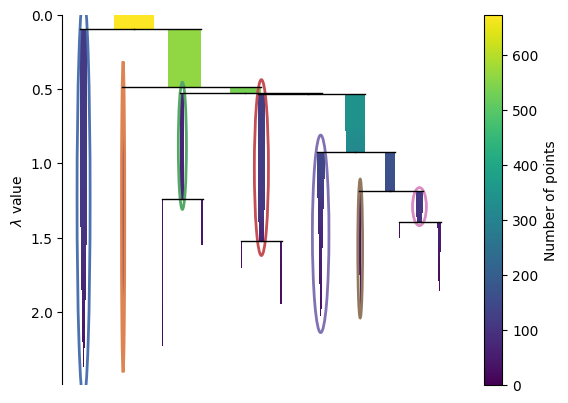

In [24]:
clusterer.condensed_tree_.plot(
    select_clusters=True,
    selection_palette=sns.color_palette('deep', 8)
)

### KMeans

In [25]:
kmeans_clusterer = AgglomerativeClustering(n_clusters=6)#, n_init=20, max_iter=10000)
kmeans_clusterer.fit(train_reduced)

AgglomerativeClustering(n_clusters=6)

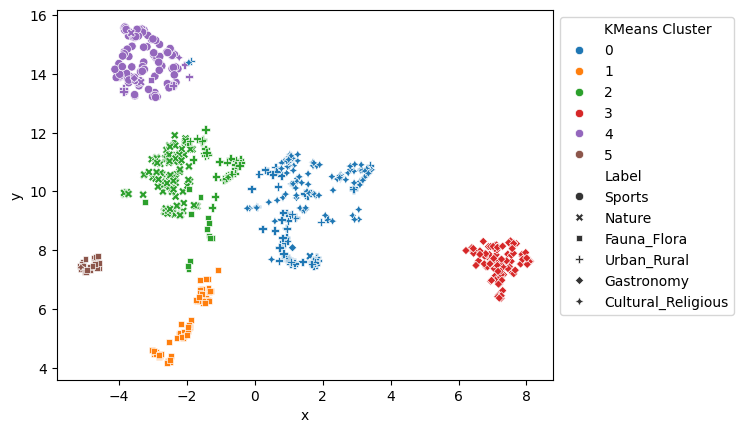

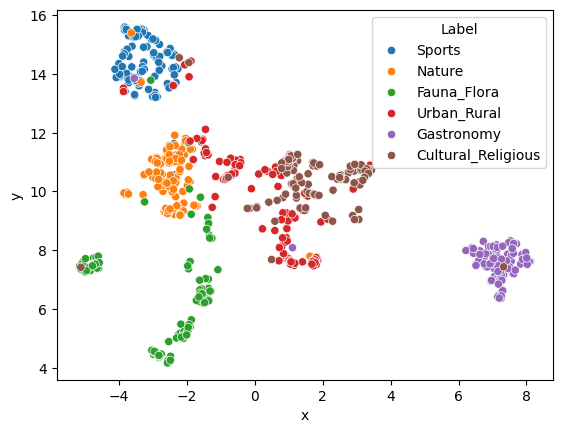

In [26]:
train_df['KMeans Cluster'] = kmeans_clusterer.labels_
ax=sns.scatterplot(
    train_df, x='x', y='y', hue='KMeans Cluster', style='Label',
    palette=sns.color_palette("tab10", n_colors=6)
)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Position outside the plot
plt.show()

sns.scatterplot(
    train_df, x='x', y='y', hue='Label', 
    palette=sns.color_palette("tab10", n_colors=6)
)
plt.show()

## Clusters BoW

Cluster -1


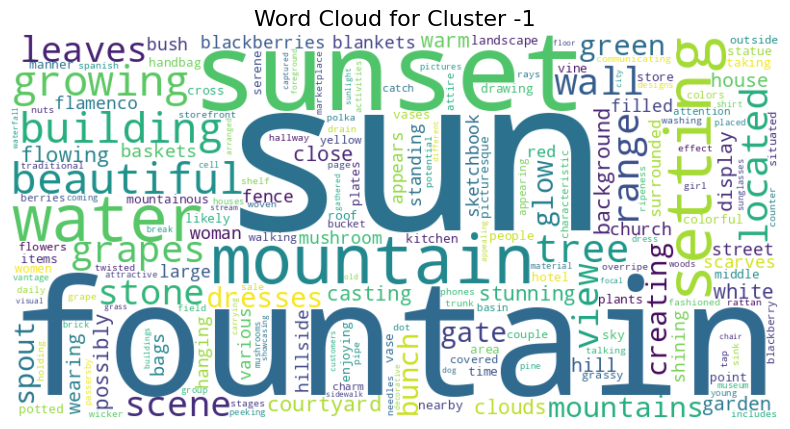

sun: 0.3050
fountain: 0.2719
sunset: 0.2346
mountain: 0.2027
water: 0.1851
setting: 0.1783
beautiful: 0.1738
growing: 0.1646
building: 0.1639
tree: 0.1440


Cluster 0


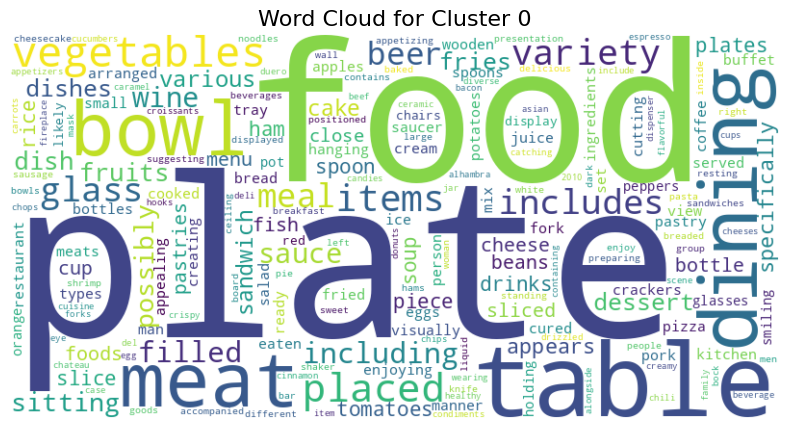

plate: 0.5919
food: 0.4632
table: 0.3508
dining: 0.2059
meat: 0.1801
bowl: 0.1737
vegetables: 0.1480
placed: 0.1292
items: 0.1132
variety: 0.1083


Cluster 1


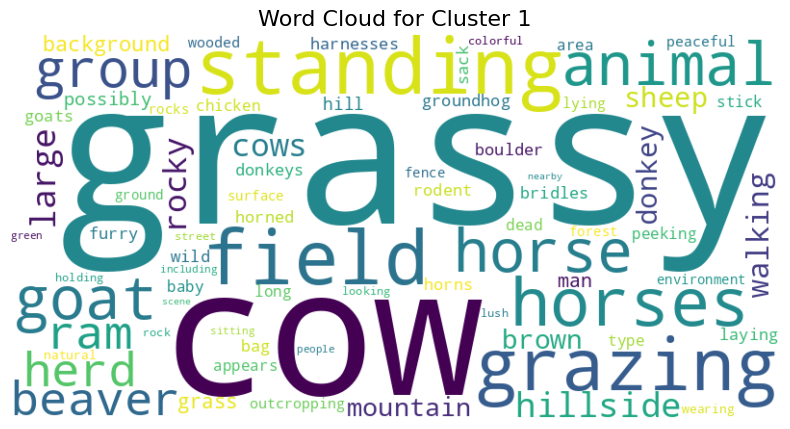

grassy: 0.4233
cow: 0.3300
standing: 0.3200
field: 0.3062
grazing: 0.2828
horses: 0.2357
animal: 0.1886
goat: 0.1886
horse: 0.1886
group: 0.1473


Cluster 2


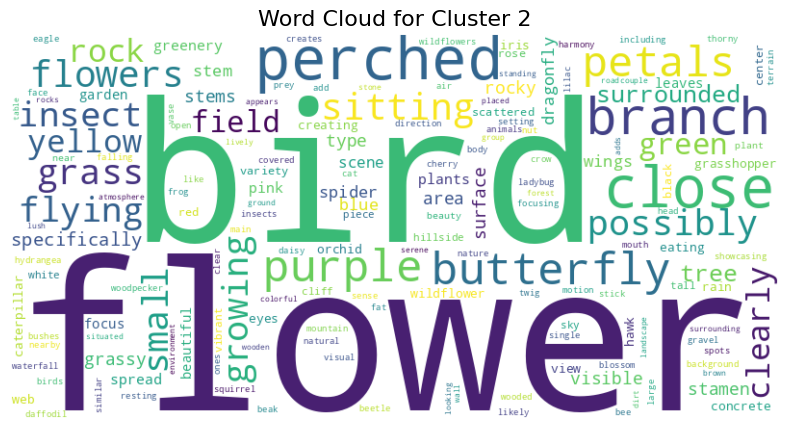

flower: 0.4343
bird: 0.3821
perched: 0.3457
close: 0.3183
branch: 0.2548
purple: 0.1842
butterfly: 0.1820
petals: 0.1638
flowers: 0.1226
sitting: 0.1218


Cluster 3


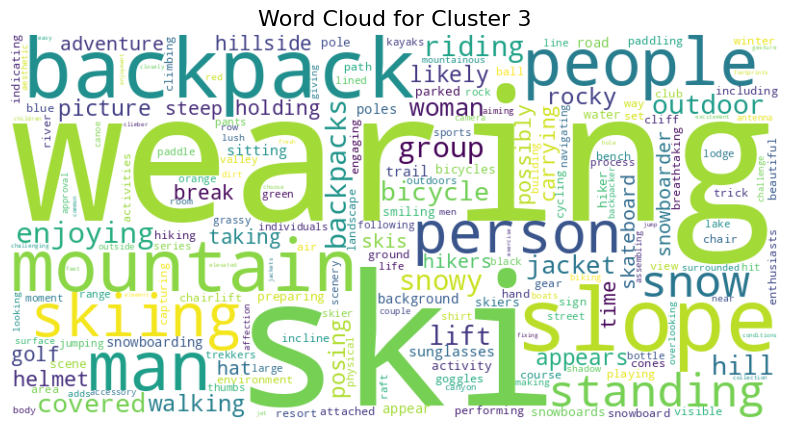

wearing: 0.3131
ski: 0.3116
slope: 0.2788
backpack: 0.2446
mountain: 0.2359
man: 0.2097
people: 0.1922
skiing: 0.1804
person: 0.1769
standing: 0.1680


Cluster 4


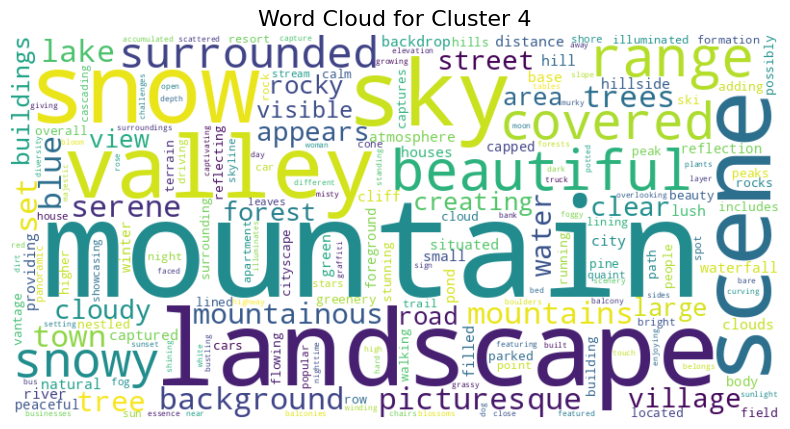

mountain: 0.5145
landscape: 0.2702
scene: 0.2331
snow: 0.2267
sky: 0.2041
valley: 0.1834
beautiful: 0.1759
range: 0.1720
covered: 0.1597
snowy: 0.1480


Cluster 5


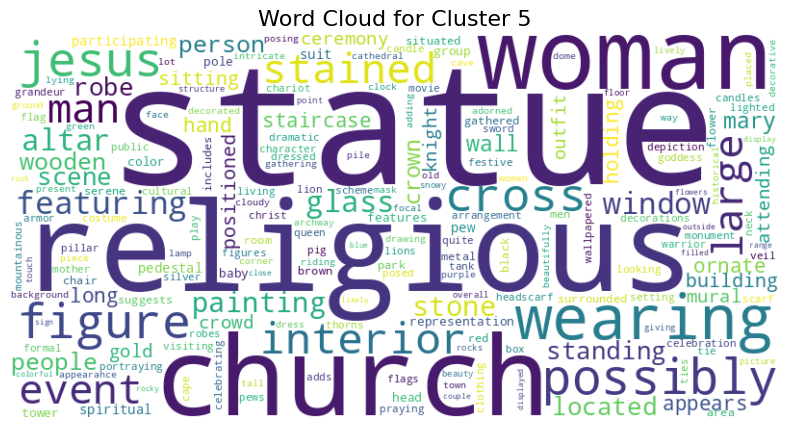

statue: 0.6447
religious: 0.3039
church: 0.2312
woman: 0.1822
wearing: 0.1706
possibly: 0.1456
figure: 0.1418
jesus: 0.1418
cross: 0.1358
interior: 0.1358


Cluster 6


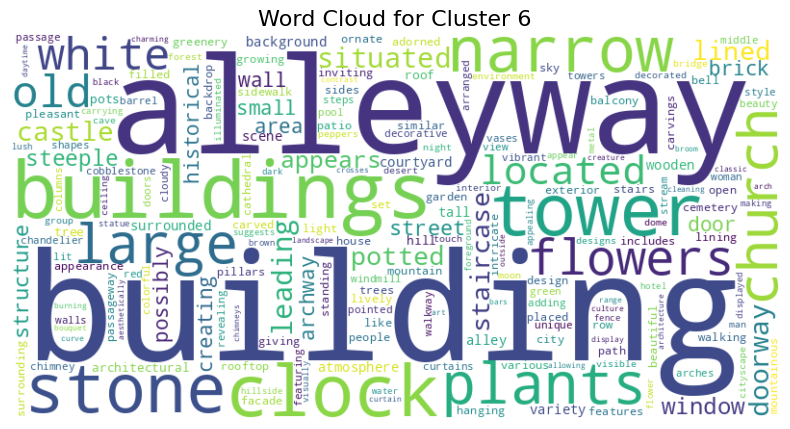

building: 0.4964
alleyway: 0.4027
buildings: 0.2798
tower: 0.2382
clock: 0.2316
stone: 0.2091
narrow: 0.1787
plants: 0.1502
large: 0.1419
church: 0.1402




In [27]:
# Step 1: Combine all documents in the same cluster into a single document
clustered_docs = train_df.groupby('HDBSCAN Cluster')['caption'].apply(' '.join).reset_index()
clustered_docs['caption'] = clustered_docs['caption'].str.replace('image', '')
clustered_docs['caption'] = clustered_docs['caption'].str.replace('shows', '')

# Step 2: Calculate the TF-IDF for the combined documents
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(clustered_docs['caption'])

# Step 3: Get the feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Step 4: Extract the top 10 words with the highest TF-IDF score for each cluster
top_n = 10
clusters_words = {}
for idx, row in enumerate(tfidf_matrix):
    representative_words = []
    cluster = clustered_docs['HDBSCAN Cluster'][idx]
    print(f"Cluster {cluster}")
    # Get the TF-IDF scores for the row and corresponding feature names
    tfidf_scores = zip(feature_names, row.toarray().flatten())
    # Convert to dictionary (word: tf-idf score)
    tfidf_dict = {word: score for word, score in tfidf_scores}
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_dict)
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster}', fontsize=16)
    plt.show()
    # Sort by TF-IDF score in descending order and get the top N words
    tfidf_scores = zip(feature_names, row.toarray().flatten())
    sorted_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)[:top_n]
    for word, score in sorted_scores:
        representative_words.append(word)
        print(f"{word}: {score:.4f}")
    print("\n")
    clusters_words[cluster] = representative_words
    

## Zero-shot cluster classification

In [28]:
llama_model_id = 'google/flan-t5-large'
labels = ['Sports', 'Nature', 'Urban and rural', 'Flora and fauna', 'Gastronomy', 'Cultural and religious']

def generate_zero_shot_classification_prompt(words, labels):
    prompt = f"""Giveng the following keywords from a cluster, classify the cluster into one category.

Keywords: {', '.join(words)}

Categories: {', '.join(labels)}
"""
    return prompt

def generate_label_generator_prompt(words):
    prompt = f"""Generate a short label (max. 3 words) that represents the cluster described by the keywords below. The label should represent the visitor who took the photo.

Keywords: {', '.join(words)}"""
    return prompt

def classify_text(model, tokenizer, words, labels, max_length=150):
    prompt = generate_zero_shot_classification_prompt(words, labels)
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(**inputs, max_length=max_length)

    # Decode the generated text
    category = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Extract the category from the generated text
    return category

def generate_label(model, tokenizer, words, max_length=3):
    prompt = generate_label_generator_prompt(words)
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(inputs["input_ids"], max_length=max_length)

    # Decode the generated text
    label = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return label


In [29]:

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(llama_model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(
    llama_model_id,
    load_in_4bit=True,
    device_map="auto",  # This automatically places the model on the available GPUs
    torch_dtype=torch.float16,  # You can use bfloat16 or float16 for better memory usage
)


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


In [30]:

for cluster, words in clusters_words.items():
    category = classify_text(model, tokenizer, words, labels)
    label = generate_label(model, tokenizer, words)
    print(f"Words: {', '.join(words)}")
    print(f"Category: {category}")
    print(f"Label: {label}")
    print("----------------------------")

    

Words: sun, fountain, sunset, mountain, water, setting, beautiful, growing, building, tree
Category: Nature
Label: building,
----------------------------
Words: plate, food, table, dining, meat, bowl, vegetables, placed, items, variety
Category: Gastronomy
Label: a
----------------------------
Words: grassy, cow, standing, field, grazing, horses, animal, goat, horse, group
Category: Nature
Label: group of
----------------------------
Words: flower, bird, perched, close, branch, purple, butterfly, petals, flowers, sitting
Category: Flora and fauna
Label: close up
----------------------------
Words: wearing, ski, slope, backpack, mountain, man, people, skiing, person, standing
Category: Sports
Label: a
----------------------------
Words: mountain, landscape, scene, snow, sky, valley, beautiful, range, covered, snowy
Category: Nature
Label: beautiful scene
----------------------------
Words: statue, religious, church, woman, wearing, possibly, figure, jesus, cross, interior
Category: Cult